# CMB DATA INSPECTION <br />

## Introduction <br />

As we know, the Cosmic Microwave Background (CMB) is the background radiation map we are able to observe from Earth corresponding to the redshifted remnant of the relic radiation. This radiation occured around $10^5$ years after the Big Bang and it corresponds to the moment where the photons could move freely through space after the recombination of matter. <br />

These photons, which where surrounded by a temperature of 3000K, reach us at microwave wavelengths due to the continous expansion of the universe which redshifted their radiation. We can detect a temperature of about 2.73K nowadays, eventhough the CMB is not very homogeneus and some observable fluctiations appear when observing. These fluctuations have a value around 0.004K. <br />

The aim of this work will be to characterize this CMB mean temperature and study the behavior of this distribution of temperatures in each observed pixel. <br />

To do this we will be using data obtained in 1989 by the Cosmic Background Explorer (COBE) satellite. We will work directly with this data set, which was obtained using the Far Infra-Red Absolute Spectrometer (FIRAS). This data is available at the NASA website. <br /> <br />

## Data analysis and fitting <br />
In first place we will go to NASA's web page and download the data. Once this is done, we will inspect the headers of the fits file and then we can start our analysis.

The first part of the analysis will be focusing on importing our data correctly. The fits file contains information about a stripe of around 6000 pixels, of which we have multiple information. The information we are interested in are the flux for each frequency value and the weight of the pixel.

The weight of the pixel is a binary value, 1 or 0. It shows if the pixel has been used to calculate the final temperature approximation or not, being of vital importance for us. <br /> <br />

### Importing and cleaning data

In this first step we will import the libraries, import the data and lastly select the pixels we will be using for our temperature fitting. It is important to know that the data didn't have a frequency column of reference, that is why we made it by knowing the minimum and maximum values and the number of values in between.

Once this is done we can move onto selecting the pixels we will use on our analysis. We basically made a loop that selects and appends the pixels that have a weight of 1. This pixels were the ones used in the original data.

Lastly, we will make a vector which gathers the mean value of the intensity for each frequency. This mean is done using all the correct pixels we selected before, which are 5883.

In [1]:
#LIBRARIES:
import numpy as np
from astropy.io import fits
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.constants import h,c,k



#IMPORTING DATA:
data = fits.open('spectra_COBE.FITS')
cube = data[1].data
minfrec = 23.80723
maxfrec = 639.527135
frec = [minfrec+(maxfrec-minfrec)*i/182 for i in range (182)]
frec = np.array(frec, dtype='float64')
frechz = [(minfrec+(maxfrec-minfrec)*i/182)*1e9 for i in range (182)]
frechz = np.array(frec, dtype='float64')
ity = []
for i in range (len(cube)):
    if cube[i][4]==1:
        ity.append(cube[i][5])

    #Mean intensity vector value for all pixels:
ity = np.matrix(ity)
itymean = ity.mean(0)
itymean = itymean.flatten().tolist()
itymean = itymean[0]

    #Standar deviation for all intensity values:
itystd = ity.std(0)
itystd = itystd.flatten().tolist()
itystd = itystd[0]

### Fitting and plotting <br /> 
Now that we have our vector of the main values we can fit the distribution of flux using the black body radiation function proposed by planck. This is what we are defining below as pl(x,T). Once defined, we can use <em>curve_fit</em>, which is a non-linear least squares method which allows for fitting of data to a given function which can be freely customized. After doing this we can plot the fitting function and that is the obtained figure shown below. The temperature we obtained is:

$$T=2.72557 \ \pm \ 0.00021$$

[0.04267083]


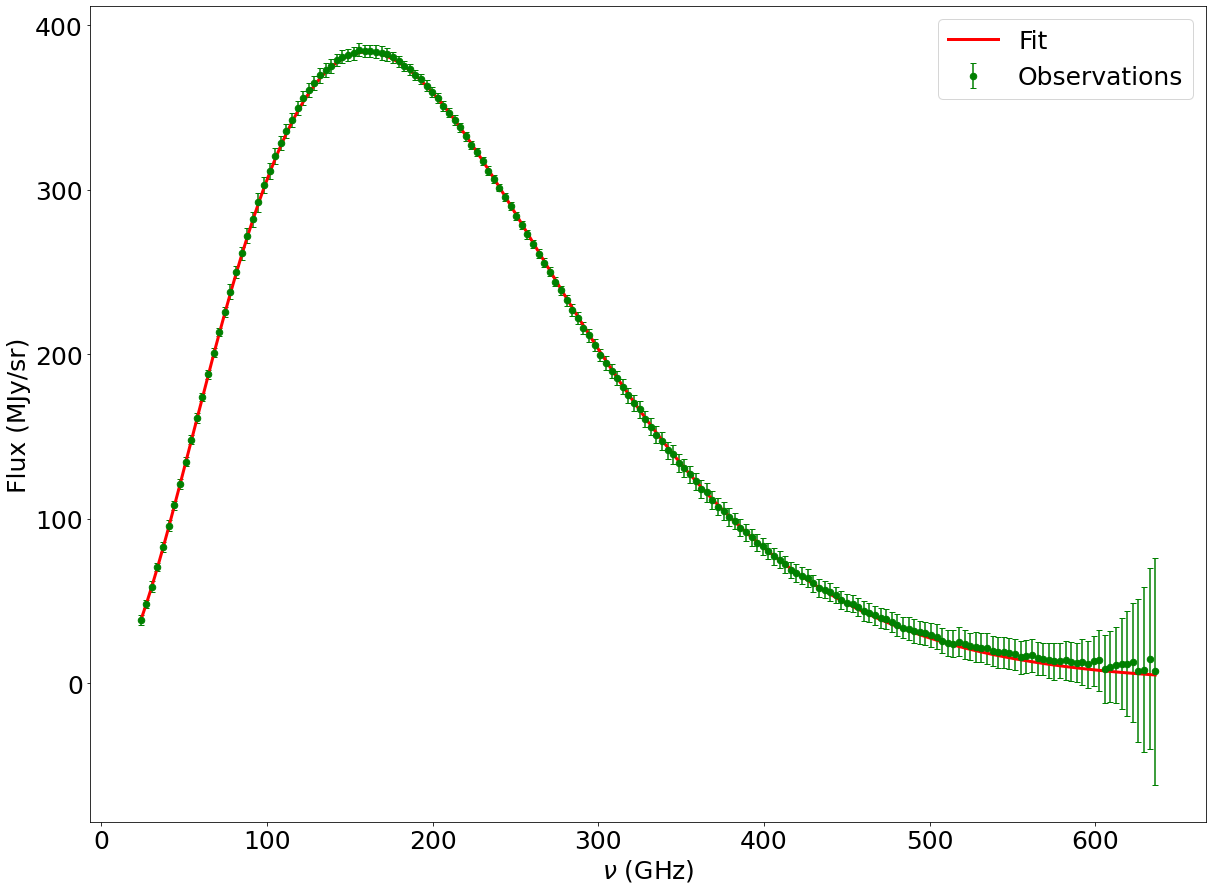

In [2]:
#FITTING DATA:
    #Defining the planck's function:
def pl(x,T):
    f = ((2*h*((x*10**9)**3))/(c**2))*(1/(np.exp((h*(x*10**9))/(k*T))-1))*10**(20)
    f = np.array(f,dtype='float64')
    return f

    #Fit:
Temp,Tcov = curve_fit(pl,frec,itymean,p0=20,sigma=itystd,bounds=(1,30))
Terr = np.sqrt(Tcov)

    #Fit's value discrepancy:
Tbib = 2.7260
disc = np.absolute(Temp-Tbib)*100
print(disc)


#PLOTTING:
    #Sizes:
plt.rc('font', size=25)          # controls default text sizes
plt.rc('axes', titlesize=25)     # fontsize of the axes title
plt.rc('axes', labelsize=25)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=25)    # fontsize of the tick labels
plt.rc('ytick', labelsize=25)    # fontsize of the tick labels

    #Plot
plt.figure(figsize=(20,15))
plt.errorbar(frec,itymean,itystd,fmt='g.',markersize=13,capsize=3,label='Observations')
plt.plot(frec,pl(frec,Temp),'r-',linewidth=3,label='Fit')
plt.legend()
plt.ylabel(r'Flux (MJy/sr)')
plt.xlabel(r'$\nu$'+' (GHz)')
plt.savefig('ajuste.png')

As we can see the planck function for this temperature is fitting the observational data perfectly. The temperature value is very close to the one found on the bibliography (see  [2]), having a discrepancy of 0.043%.
<br /><br />

### Temperature distribution.
On first place we calculated the mean value of the flux for each frequency to have an easier way to approach our problem, but we can also study the distribution of temperatures for each pixel. To do this we can take each pixel's flux vector and fit the planck function to its distribution. Then, with a temperature value for each of the pixels we can make a histogram, which is shown below.

We can easily make a comparison of the behavior of the histogram and a gaussian distribution centered in the average Temperature value. This is what we do  below.

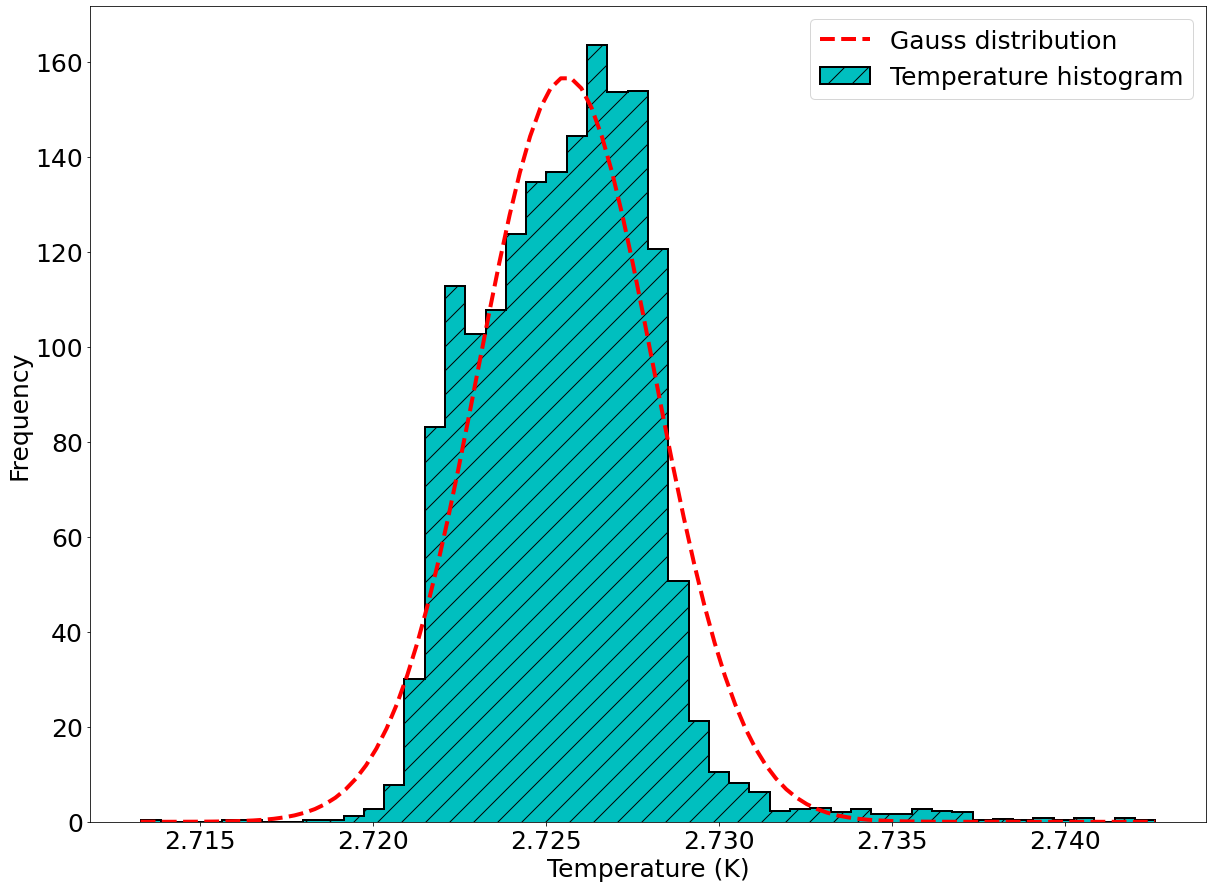

In [3]:
#HISTOGRAM OF TEMPERATURES:
    #Vector defining and importing:
temps = []
tempscov = []
for i in range(0,len(ity)-1):
    ityi = np.matrix(ity[i])
    ityi = ityi.flatten().tolist()[0]
    Temp,Tcov=curve_fit(pl,frec,ityi,p0=20,sigma=itystd,bounds=(1,30))
    temps.append(Temp)
    tempscov.append(Tcov)
tempslist = (np.matrix(np.stack(temps))).flatten().tolist()[0]

    #Gaussian defining:
avg = np.mean(tempslist)
dev = np.var(tempslist)
xgauss = np.linspace(np.min(tempslist),np.max(tempslist),100)
ygauss = 1.0/np.sqrt(2*np.pi*dev)*np.exp(-0.5*(xgauss-avg)**2/dev)

    #Plotting histogram:
plt.figure(figsize=(20,15))
plt.hist(tempslist,50,histtype='step',facecolor='c', hatch='/', edgecolor='k',linewidth=2,fill=True,label='Temperature histogram',density=True)
plt.plot(xgauss,ygauss,'r--',linewidth=4,label='Gauss distribution')
plt.legend()
plt.ylabel(r'Frequency')
plt.xlabel(r'Temperature (K)')
plt.savefig('ajuste.png')

Both the histogram and the gaussian distribution have a very similar shape. This confirms the temperature fluctuations follow a gaussian distribution and are the result of random processes that occured in the first instants of the universe. <br /> <br />

## Conclusions
The data treatment and fit results of the project show how the CMB temperature can be calculated with a very acceptable precission using a public dataset and little effort with python. This shows the power of python, which for this cases, is a very practical and effective language to use. <br /> <br /> <br /> 

## Bibliography

[1] DICKIE, R. H., PEEBLES, P. J. E., ROLL, P. G., & WILKINSON, D. T. (1965). <em>Cosmic black-body radiation</em>. The Astrophysical Journal, 142, 414-419, May 1965. <br />

[2] FIXSEN , D. J., <em>The Temperature of the Cosmic Microwave Background</em>, Astrophysical Journal, 707, 916-920, Nov. 2009<br />

[3] FRANCISCO SHU KITAURA. <em>Técnicas computacionales básicas, apuntes completos</em>. 2021 <br />
    
[4] AGHANIM, Nabila, et al. Planck 2015 results-XI. <em>CMB power spectra, likelihoods, and robustness of parameters</em>. Astronomy & Astrophysics, 2016, vol. 594, p. A11.